In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt



psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 2, 3, 4, 5, 6, 7, 8]
n = 3
number_of_layers = 2

psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()


# circuit
def build_experiment_circuit(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    cregs = [ClassicalRegister(n, name=f"c{k}") for k in range(m)]
    qc = QuantumCircuit(psi_reg, phi_reg, *cregs)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for k in range(m):
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])

        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        qc.append(U_phi_dagger, phi_reg)

        # >>> Save statevector of final iteration BEFORE measurement <<<
        if k == m - 1:
            qc.save_statevector("sv")

        qc.measure(phi_reg, cregs[k])
        qc.reset(phi_reg)

        if k < m - 1:
            qc.append(U_phi, phi_reg)

    return qc


In [15]:
def run_successful_shot(delta, m, max_trials=200, shots=5):
    sim = AerSimulator()
    qc = build_experiment_circuit(delta, m)
    tqc = transpile(qc, sim)

    zero_state = "0" * n

    for trial in range(max_trials):
        shots = 5
        result = sim.run(tqc, shots=shots, memory=True).result()
        memories = result.get_memory(tqc)

        for mem in memories:
            parts = mem.split(" ")
            if all(p == zero_state for p in parts):
                print(f"✅ Success for m={m} on trial {trial+1} → {mem}")

                # Extract statevector from THIS exact successful run
                data = result.data(0)
                sv = data["sv"]
                return True, sv

    print(f"❌ No success for m={m} after {max_trials} trials.")
    return False, None


In [16]:
def fidelity_from_successful_statevector(sv, delta, m):
    # Trace out φ subsystem: qubits n..2n-1 are ancilla
    rho_psi = partial_trace(sv, list(range(n, 2*n)))

    # Ideal ψ
    psi_vec = np.array(psi, dtype=complex) / np.linalg.norm(psi)
    phi_vec = np.array(phi, dtype=complex) / np.linalg.norm(phi)

    # Ideal programmable phase
    # exp(i * delta * m * |phi(x)|^2)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)

    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # Fidelity
    fid = state_fidelity(rho_psi, rho_ideal)
    return fid


In [17]:
def fidelity_success_run(delta, m, max_trials=200, shots=5):
    success, sv = run_successful_shot(delta, m, max_trials=max_trials, shots=shots)

    if not success:
        print(f"No success → fidelity = NaN")
        return np.nan

    fid = fidelity_from_successful_statevector(sv, delta, m)
    print(f"Fidelity for m={m}: {fid:.4f}")
    return fid


✅ Success for m=1 on trial 1 → 000
Fidelity for m=1: 0.9963
✅ Success for m=2 on trial 1 → 000 000
Fidelity for m=2: 0.9963
✅ Success for m=3 on trial 1 → 000 000 000
Fidelity for m=3: 0.9963
✅ Success for m=4 on trial 1 → 000 000 000 000
Fidelity for m=4: 0.9963
✅ Success for m=5 on trial 1 → 000 000 000 000 000
Fidelity for m=5: 0.9963
✅ Success for m=6 on trial 1 → 000 000 000 000 000 000
Fidelity for m=6: 0.9963
✅ Success for m=7 on trial 1 → 000 000 000 000 000 000 000
Fidelity for m=7: 0.9963
✅ Success for m=8 on trial 1 → 000 000 000 000 000 000 000 000
Fidelity for m=8: 0.9963
✅ Success for m=9 on trial 1 → 000 000 000 000 000 000 000 000 000
Fidelity for m=9: 0.9963
✅ Success for m=10 on trial 1 → 000 000 000 000 000 000 000 000 000 000
Fidelity for m=10: 0.9963
✅ Success for m=11 on trial 1 → 000 000 000 000 000 000 000 000 000 000 000
Fidelity for m=11: 0.9963
✅ Success for m=12 on trial 1 → 000 000 000 000 000 000 000 000 000 000 000 000
Fidelity for m=12: 0.9963
✅ Success 

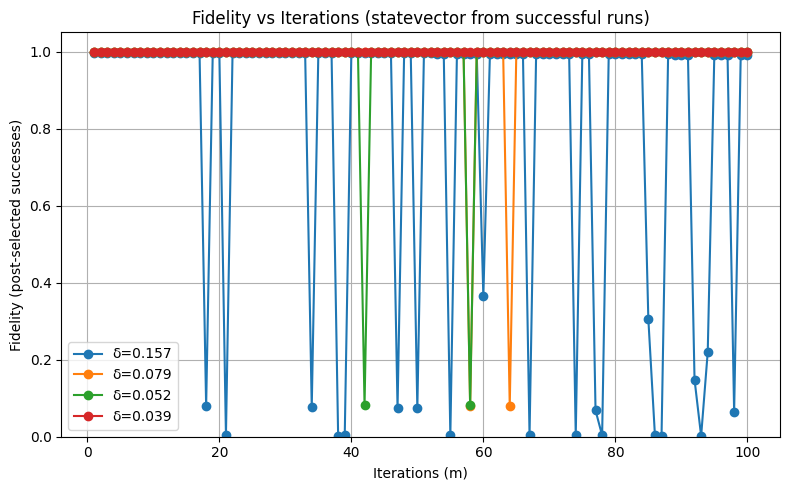

In [21]:
def plot_fidelity_vs_iterations(delta_values, max_m, max_trials=200, shots=5):
    plt.figure(figsize=(8,5))

    for delta in delta_values:
        fids = []
        m_values = np.arange(1, max_m+1)

        for m in m_values:
            fidelity = fidelity_success_run(delta, m,
                                            max_trials=max_trials,
                                            shots=shots)
            fids.append(fidelity)

        plt.plot(m_values, fids, "o-", label=f"δ={delta:.3f}")

    plt.xlabel("Iterations (m)")
    plt.ylabel("Fidelity (post-selected successes)")
    plt.title("Fidelity vs Iterations (statevector from successful runs)")
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Run the plot
delta_values = [np.pi/20, np.pi/40, np.pi/60, np.pi/80]
plot_fidelity_vs_iterations(delta_values, max_m=100)
